In [1]:
%matplotlib inline

import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

# Plot configurations
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})
sns.set_style("darkgrid")
custom_style = {
            'grid.color': '0.8',
            'grid.linestyle': '--',
            'grid.linewidth': 0.5,
}
sns.set_style(custom_style)

In [2]:
# Run parameters

DATA_DIR = "csse_covid_19_daily_reports/"
MIN_DATE = "2020-03-22"
MAX_DATE = "2020-03-31"

# Add these back after rank filtering
STATE_INCLUDE_LIST = []
CITY_INCLUDE_LIST = []

# Exclude globally
STATE_EXCLUDE_LIST = []
CITY_EXCLUDE_LIST = ["Unassigned"]

# Manually set states or cities globally
STATE_OVERRIDE_LIST = ["North Carolina", "South Carolina", "Georgia", "Virginia"]
CITY_OVERRIDE_LIST = []

# Limit to top n on max input date
CITY_LIMIT = 10
STATE_LIMIT = 10

In [3]:
# Data sample pre-3/22

pd.read_csv(DATA_DIR + "03-21-2020.csv").head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-21T10:13:08,67800,3139,58946,30.9756,112.2707
1,NaN,Italy,2020-03-21T17:43:03,53578,4825,6072,41.8719,12.5674
2,NaN,Spain,2020-03-21T13:13:30,25374,1375,2125,40.4637,-3.7492
3,NaN,Germany,2020-03-21T20:43:02,22213,84,233,51.1657,10.4515
4,NaN,Iran,2020-03-21T11:13:12,20610,1556,7635,32.4279,53.6880


In [4]:
# Data sample post-3/22

pd.read_csv(DATA_DIR + "03-22-2020.csv").head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,36061.0,New York City,New York,US,3/22/20 23:45,40.767273,-73.971526,9654,63,0,0,"New York City, New York, US"
1,36059.0,Nassau,New York,US,3/22/20 23:45,40.740665,-73.589419,1900,4,0,0,"Nassau, New York, US"
2,36119.0,Westchester,New York,US,3/22/20 23:45,41.162784,-73.757417,1873,0,0,0,"Westchester, New York, US"
3,36103.0,Suffolk,New York,US,3/22/20 23:45,40.883201,-72.801217,1034,9,0,0,"Suffolk, New York, US"
4,36087.0,Rockland,New York,US,3/22/20 23:45,41.150279,-74.025605,455,1,0,0,"Rockland, New York, US"


In [5]:
def build_aggregate_df():

    agg_df = None

    for fn in glob.glob(DATA_DIR + "*.csv"):
        df = pd.read_csv(fn)
        df["Date"] = fn.split("/")[-1].split(".csv")[0]
        df.rename(columns={
            "Country/Region": "Country_Region", 
            "Province/State": "Province_State",
            "Lat": "Latitude",
            "Long_": "Longitude",
            "Last Update": "Last_Update",
            "Admin2": "City"
        }, inplace=True)
        if agg_df is None:
            agg_df = df
        else:
            agg_df = agg_df.append(df, ignore_index=True)

    agg_df["Date"] = pd.to_datetime(agg_df["Date"])
    
    # Limit date range
    agg_df = agg_df[agg_df["Date"].between(MIN_DATE, MAX_DATE)]
    
    # Filter for U.S. only
    agg_df = agg_df[agg_df["Country_Region"]=="US"]
    
    # Filter Exclusion Lists
    agg_df = agg_df[~agg_df.Province_State.isin(STATE_EXCLUDE_LIST)]
    agg_df = agg_df[~agg_df.City.isin(CITY_EXCLUDE_LIST)]
    
    if STATE_OVERRIDE_LIST:
        agg_df = agg_df[agg_df.Province_State.isin(STATE_OVERRIDE_LIST)]
        
    if CITY_OVERRIDE_LIST:
        agg_df = agg_df[agg_df.City.isin(CITY_OVERRIDE_LIST)]

    print("Num Rows:", agg_df.shape[0])
    print("Total Dates:", agg_df["Date"].unique().shape[0])
    print("Min Date:", agg_df["Date"].min())
    print("Max Date:", agg_df["Date"].max())
    
    return agg_df

agg_df = build_aggregate_df()

agg_df.head()

Num Rows: 4299
Total Dates: 10
Min Date: 2020-03-22 00:00:00
Max Date: 2020-03-31 00:00:00


,FIPS,City,Province_State,Country_Region,Last_Update,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
0,45001.0,Abbeville,South Carolina,US,2020-03-23 23:19:34,34.223334,-82.461707,1.0,0.0,0.0,0.0,"Abbeville, South Carolina, US",2020-03-23
2,51001.0,Accomack,Virginia,US,2020-03-23 23:19:34,37.767072,-75.632346,1.0,0.0,0.0,0.0,"Accomack, Virginia, US",2020-03-23
21,45003.0,Aiken,South Carolina,US,2020-03-23 23:19:34,33.543380,-81.636454,1.0,0.0,0.0,0.0,"Aiken, South Carolina, US",2020-03-23
24,37001.0,Alamance,North Carolina,US,2020-03-23 23:19:34,36.043470,-79.399761,2.0,0.0,0.0,0.0,"Alamance, North Carolina, US",2020-03-23
29,51003.0,Albemarle,Virginia,US,2020-03-23 23:19:34,38.020807,-78.554811,2.0,0.0,0.0,0.0,"Albemarle, Virginia, US",2020-03-23


In [6]:
def build_state_df(agg_df):
    
    state_df = agg_df[["Date", "Province_State", "Confirmed"]]

    # Limit to top n locales
    include = (
        state_df[state_df.Date==MAX_DATE]
        .groupby('Province_State')
        .sum()
        .sort_values("Confirmed", ascending=False)
    )[:STATE_LIMIT].index.to_list()
    
    include.extend(STATE_INCLUDE_LIST)
    
    print("Included states:\n", include)
    state_df = state_df[state_df['Province_State'].isin(include)]
    
    return state_df

state_df = build_state_df(agg_df)

state_df.head()

Included states:
 ['Georgia', 'North Carolina', 'Virginia', 'South Carolina']


,Date,Province_State,Confirmed
0,2020-03-23,South Carolina,1.0
2,2020-03-23,Virginia,1.0
21,2020-03-23,South Carolina,1.0
24,2020-03-23,North Carolina,2.0
29,2020-03-23,Virginia,2.0


In [7]:
def build_city_df(agg_df):
    city_df = agg_df[["Date", "City", "Confirmed"]]
    
    # Limit to top n locales
    include = (
        city_df[city_df.Date==MAX_DATE]
        .groupby('City')
        .sum()
        .sort_values("Confirmed", ascending=False)
    )[:CITY_LIMIT].index.to_list()
    
    include.extend(CITY_INCLUDE_LIST)
    
    print("Included cities:\n", include)
    city_df = city_df[city_df['City'].isin(include)]
    
    return city_df

city_df = build_city_df(agg_df)

city_df.head()

Included cities:
 ['Fulton', 'Dougherty', 'Mecklenburg', 'DeKalb', 'Cobb', 'Fairfax', 'Gwinnett', 'Wake', 'Richland', 'Charleston']


,Date,City,Confirmed
451,2020-03-23,Charleston,31.0
581,2020-03-23,Cobb,79.0
739,2020-03-23,DeKalb,75.0
805,2020-03-23,Dougherty,64.0
899,2020-03-23,Fairfax,43.0


In [8]:
def build_cumulative_df(locale_df, locale_column="Province_State"):

    cum_df = locale_df.groupby(by=["Date", locale_column]).sum()

    cum_df = cum_df.unstack()
    cum_df.columns = cum_df.columns.droplevel()
    cum_df.reset_index(level=0, inplace=True)
    
    return cum_df
    
cum_state_df = build_cumulative_df(state_df, "Province_State")

cum_state_df.head()

Province_State,Date,Georgia,North Carolina,South Carolina,Virginia
0,2020-03-22,585.0,305.0,196.0,220.0
1,2020-03-23,727.0,353.0,298.0,254.0
2,2020-03-24,945.0,495.0,342.0,293.0
3,2020-03-25,1101.0,590.0,424.0,396.0
4,2020-03-26,1359.0,738.0,424.0,466.0


In [9]:
cum_city_df = build_cumulative_df(city_df, "City")

cum_city_df.head()

City,Date,Charleston,Cobb,DeKalb,Dougherty,Fairfax,Fulton,Gwinnett,Mecklenburg,Richland,Wake
0,2020-03-22,13.0,67.0,53.0,52.0,31.0,111.0,27.0,78.0,29.0,52.0
1,2020-03-23,31.0,79.0,75.0,64.0,43.0,145.0,34.0,98.0,43.0,52.0
2,2020-03-24,36.0,86.0,94.0,90.0,46.0,184.0,45.0,144.0,45.0,66.0
3,2020-03-25,52.0,101.0,116.0,109.0,76.0,198.0,48.0,173.0,59.0,73.0
4,2020-03-26,52.0,115.0,129.0,156.0,79.0,211.0,75.0,207.0,59.0,100.0


In [10]:
def build_normalized_state_df(cum_df, start_n=200):
    normalized_df = pd.DataFrame(columns=["Province_State", "Confirmed"])

    for state in cum_df.columns[1:]:
        df = cum_df[state].to_frame()
        df.columns = ["Confirmed"]
        df = df[df.Confirmed>start_n].reset_index(drop=True)
        df["Province_State"] = state
        normalized_df = normalized_df.append(df)
        
    normalized_df['Date'] = normalized_df.index
    normalized_df = build_cumulative_df(normalized_df, "Province_State")
        
    return normalized_df
        
normalized_state_df = build_normalized_state_df(cum_state_df)
    
normalized_state_df.head()

Province_State,Date,Georgia,North Carolina,South Carolina,Virginia
0,0,585.0,305.0,298.0,220.0
1,1,727.0,353.0,342.0,254.0
2,2,945.0,495.0,424.0,293.0
3,3,1101.0,590.0,424.0,396.0
4,4,1359.0,738.0,542.0,466.0


In [11]:
def build_normalized_city_df(cum_df, start_n=200):
    normalized_df = pd.DataFrame(columns=["City", "Confirmed"])

    for city in cum_df.columns[1:]:
        df = cum_df[city].to_frame()
        df.columns = ["Confirmed"]
        df = df[df.Confirmed>start_n].reset_index(drop=True)
        df["City"] = city
        normalized_df = normalized_df.append(df)
        
    normalized_df['Date'] = normalized_df.index
    normalized_df = build_cumulative_df(normalized_df, "City")
        
    return normalized_df
        
normalized_city_df = build_normalized_city_df(cum_city_df)
    
normalized_city_df.head()

City,Date,Cobb,DeKalb,Dougherty,Fairfax,Fulton,Gwinnett,Mecklenburg
0,0,222.0,240.0,205.0,224.0,211.0,238.0,207.0
1,1,245.0,272.0,239.0,244.0,307.0,NaN,263.0
2,2,279.0,281.0,267.0,NaN,373.0,NaN,303.0
3,3,NaN,335.0,462.0,NaN,407.0,NaN,340.0
4,4,NaN,NaN,NaN,NaN,463.0,NaN,386.0


In [12]:
def legend_positions(df, y):
    """ Calculate position of labels to the right in plot... """
    positions = {}
    
    for column in y:
        positions[column] = df[df[column].notnull()][column].values[-1] - 0.5  

    def push():
        """
        ...by putting them to the last y value and
        pushing until no overlap
        """
        collisions = 0
        for column1, value1 in positions.items():
            for column2, value2 in positions.items():
                if column1 != column2:
                    dist = abs(value1-value2)
                    if dist < 2.5:
                        collisions += 1
                        if value1 < value2:
                            positions[column1] -= .1
                            positions[column2] += .1
                        else:
                            positions[column1] += .1
                            positions[column2] -= .1
                        return True
    while True:
        pushed = push()
        if not pushed:
            break

    return positions

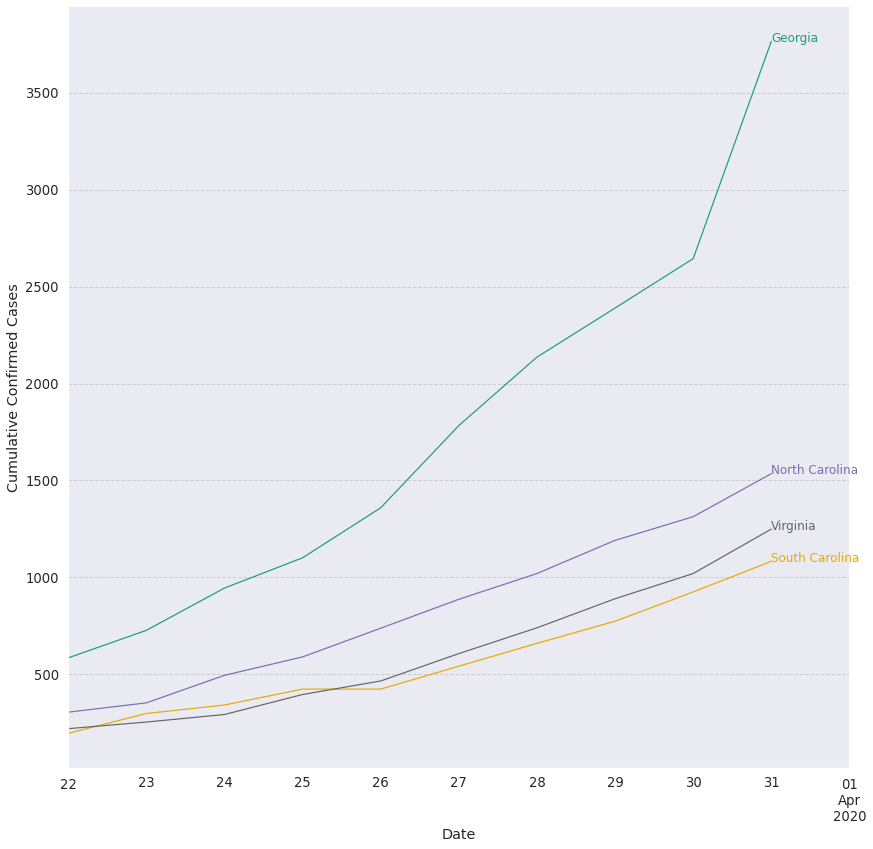

In [13]:
def plot_case_growth(df):
    plot_df = df.copy()
    x = 'Date'
    y = plot_df.columns.tolist()[1:]
    
    f, ax = plt.subplots(figsize=(14, 14))        
    cmap = plt.cm.get_cmap('Dark2', len(y))
    
    # Generate positions
    positions = legend_positions(plot_df, y)
    
    for i, (column, position) in enumerate(positions.items()):

        # Get a color
        color = cmap(float(i)/len(positions))
        # Plot each line separatly so we can be explicit about color
        ax = plot_df.plot(x=x, y=column, legend=False, ax=ax, color=color)

        # Add the text to the right
        plt.text(
            plot_df[x][plot_df[column].last_valid_index()],
            position, column, fontsize=12,
            color=color # Same color as line
        )
    ax.set_ylabel('Cumulative Confirmed Cases')
    
    if plot_df.Date.dtype == "int":
        ax.set(xlim=(0, plot_df.Date.max() + 1))
        ax.set_xlabel('Num Days')
    else:
        ax.set(xlim=(MIN_DATE, plot_df.Date.max() + pd.DateOffset(days=1)))

    sns.despine()
    
plot_case_growth(cum_state_df)

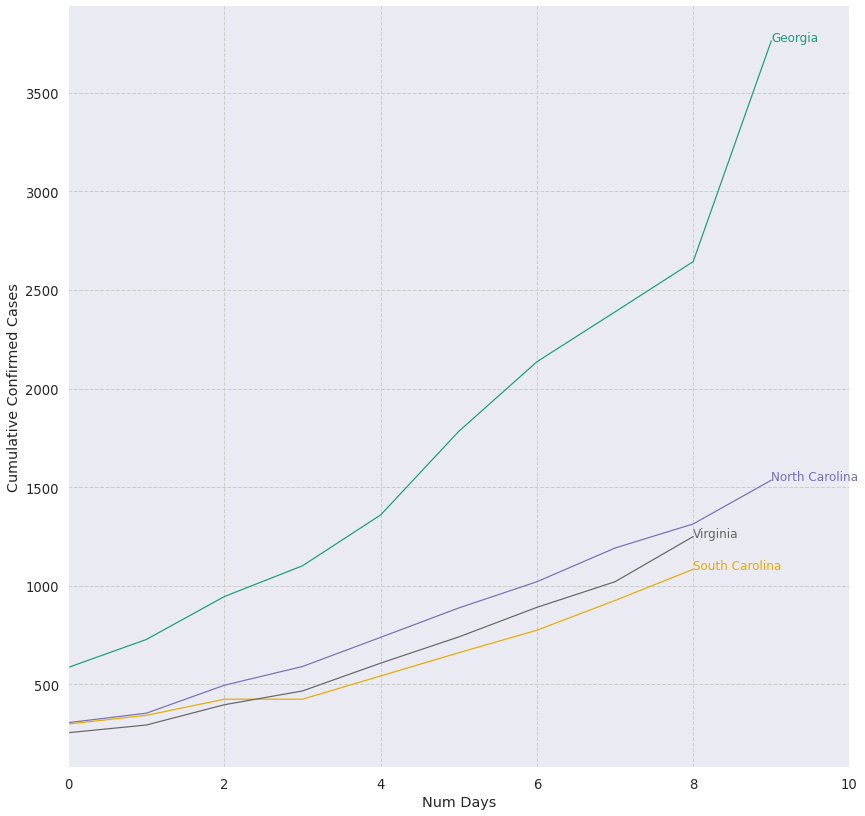

In [14]:
plot_case_growth(build_normalized_state_df(cum_state_df, start_n=250))

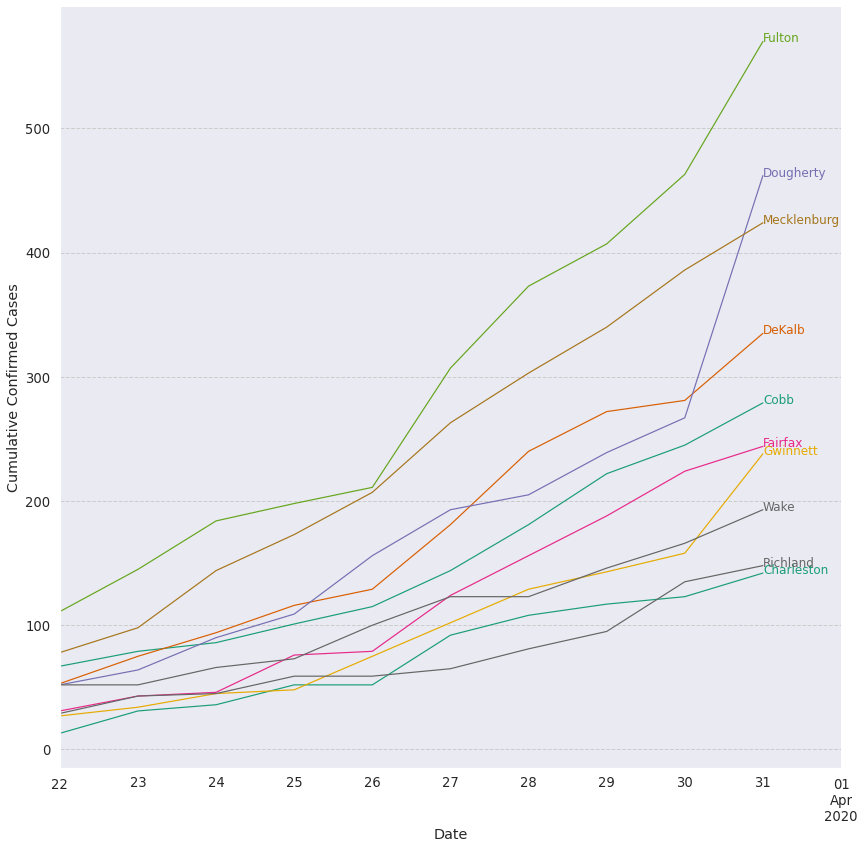

In [15]:
plot_case_growth(cum_city_df)

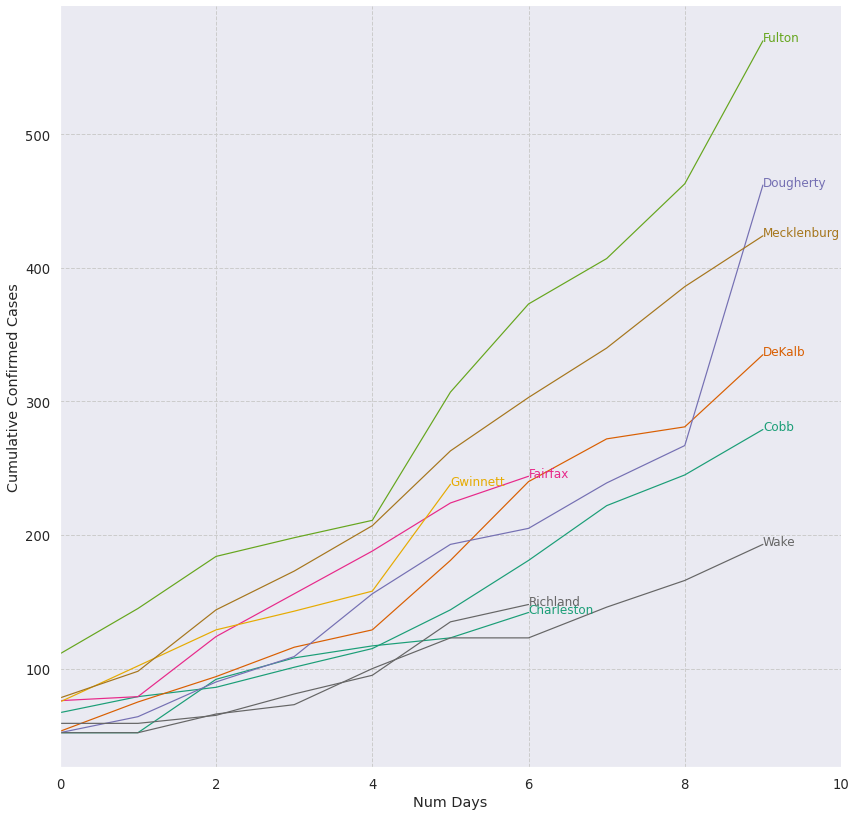

In [16]:
plot_case_growth(build_normalized_city_df(cum_city_df, start_n=50))